In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.ndimage import measurements 
from sklearn.svm import LinearSVC, SVC
import glob
import os
import time
import pickle

#import classifier
import features
import utils
import search
import viz
import detection
%matplotlib inline

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

## Step 1: read a list of images

In [2]:
# images are divided up into vehicles and non-vehicles folders 

# 1. Vehicle images
basedir = 'training/vehicles/'
# Different folders represent different sources fro images e.g. GTI, Kitti, generated by me
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))

print('Number of Vehicle Images found:', len(cars))  # 8792
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn + '\n')
        
# 2. Non-Vehicle images
basedir = 'training/non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir + imtype + '/*'))

print('Number of Non-Vehicle Images found:', len(notcars)) # 8968


Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


In [3]:
data_info = utils.data_look(cars, notcars)
for label, value in data_info.items():
    print(label,':', value)


n_cars : 8792
n_notcars : 8968
image_shape : (64, 64, 3)
data_type : float32


## Step 2: Feature Extraction

In [87]:
#### Feature Extraction Parameters #######

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations typical values 6-12
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL" (vis must be False)
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


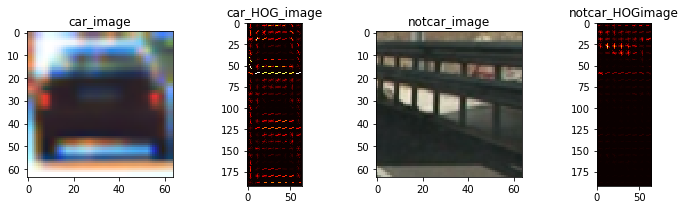

In [88]:
# Visualise the Features

# Choose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


car_features, car_hog_image = features.extract_features(car_image, color_space=color_space, spatial_size=spatial_size,
                                                  hist_bins=hist_bins, orient=orient,
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                  hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat,
                                                  hog_feat=hog_feat,
                                                  vis=True)

notcar_features, notcar_hog_image = features.extract_features(notcar_image, color_space=color_space,
                                                        spatial_size=spatial_size,
                                                        hist_bins=hist_bins, orient=orient,
                                                        pix_per_cell=pix_per_cell,
                                                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                        spatial_feat=spatial_feat, hist_feat=hist_feat,
                                                        hog_feat=hog_feat,
                                                        vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car_image', 'car_HOG_image', 'notcar_image', 'notcar_HOGimage']
fig = plt.figure(figsize=(12, 3)) 
viz.visualize(1, 4, images, titles)

### Write examples to output directory

In [89]:
for image, title in zip(images, titles):
    img_dims = len(image.shape)
    if img_dims < 3:
        heated = cv2.applyColorMap(np.uint8(255*image), cv2.COLORMAP_HOT)
        heated = np.float32(heated) / 255
        cv2.imwrite('output_images/'+title+'.jpg', np.array(255*(heated/np.max(heated)), np.uint8))
    else:
        cv2.imwrite('output_images/'+title+'.jpg', cv2.cvtColor(np.array(255*image, np.uint8), cv2.COLOR_RGB2BGR)) 

In [62]:
t=time.time()

car_features = features.extract_features_from_files(cars, color_space=color_space, spatial_size=spatial_size,
                                                    hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                    cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = features.extract_features_from_files(notcars, color_space=color_space, spatial_size=spatial_size,
                                                       hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                       cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features from all files...')

# Create an array stack of feature vectors and their labels
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=rand_state)
    
# Scaling training data only to avoid leaking test data info into the classifier
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


# Print feature parameter summary
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


/home/demo/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


79.59 Seconds to extract features from all files...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## Step3: Choosing Classifier

In [10]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

print(clf.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [11]:
# Use a linear SVC 
svc = LinearSVC()

# Training
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Testing
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


6.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9924


In [63]:
# Use a RBF SVC 
svc = SVC(kernel='rbf',C=10)

# Training
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Testing
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

557.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9955


In [13]:
# Save Linear SVC Classifier

dist_pickle = {}
dist_pickle['svc'] = svc
dist_pickle['X_scaler'] = X_scaler
dist_pickle['orient'] = orient
dist_pickle['pix_per_cell'] = pix_per_cell
dist_pickle['cell_per_block'] = cell_per_block
dist_pickle['spatial_size'] = spatial_size
dist_pickle['hist_bins'] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", "wb"), protocol=pickle.DEFAULT_PROTOCOL)


## Step 4: Develop window search algorithm 

In [64]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
# y_start_stop = [None, None]  # Min and max in y to search in slide_window(). Trees tops caused false positives
y_start_stop = [400, 656]  # Min and max in y to search in slide_window(). Trees tops caused false positives
overlap = 0.5  # 50% overlap
window_size = 96

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255  # IMPORTANT : reading *.jpeg's (scaled 0-255), but trained on *.png's (scaled 0-1)

    assert 0 <= np.min(img) <= 1.0 and 0<= np.max(img) <= 1

    windows = search.slide_window(img.shape, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(window_size, window_size), xy_overlap=(overlap, overlap))  # window size multiples of 32

    hot_windows = search.search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                                 hog_feat=hog_feat)

    window_img = viz.draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time() - t, 'seconds to process one image searching', len(windows), 'windows')


/home/demo/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


672.9911687374115 seconds to process one image searching 100 windows
676.4586935043335 seconds to process one image searching 100 windows
679.9784364700317 seconds to process one image searching 100 windows
683.5189008712769 seconds to process one image searching 100 windows
687.1907367706299 seconds to process one image searching 100 windows
690.627552986145 seconds to process one image searching 100 windows


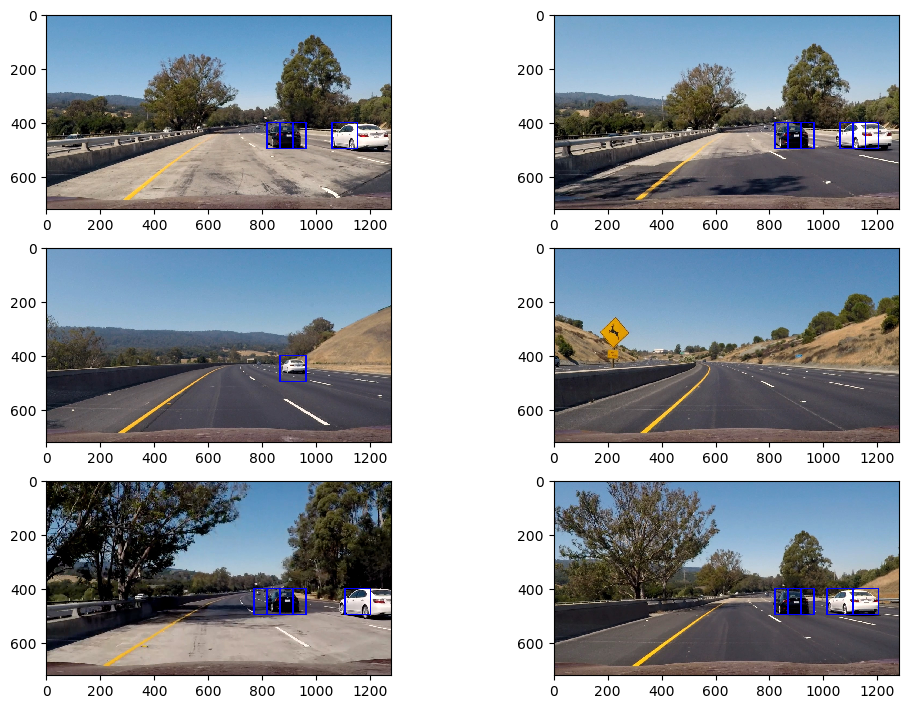

In [67]:
fig = plt.figure(figsize=(12, 18), dpi=100)
# Note sure why subplot show images better with more rows than necessary!
viz.visualize(len(images), 2, images, titles)

### Write examples to output directory

In [68]:
for idx, image in enumerate(images):
    cv2.imwrite('output_images/'+'sliding_window_{}'.format(idx)+'.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR)) 


In [71]:
# Set Region of Interest and Scale window inspection technique.
ystart = 400
ystop = 656
scale = 1.5

# Load Linear SVC Classifier
dist_pickle = pickle.load(open("svc_pickle.p", "rb"))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

In [70]:
out_images = []
out_titles = []
scale = 1.5

car_finder = detection.car_finder(scale, [ystart, ystop], orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, X_scaler, svc)

# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, out_boxes, heat_map = car_finder.find_cars(img) 
    labels = measurements.label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = viz.draw_labeled_boxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(np.copy(heat_map))
    out_titles.append(img_src)
    out_titles.append(img_src)


/home/demo/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


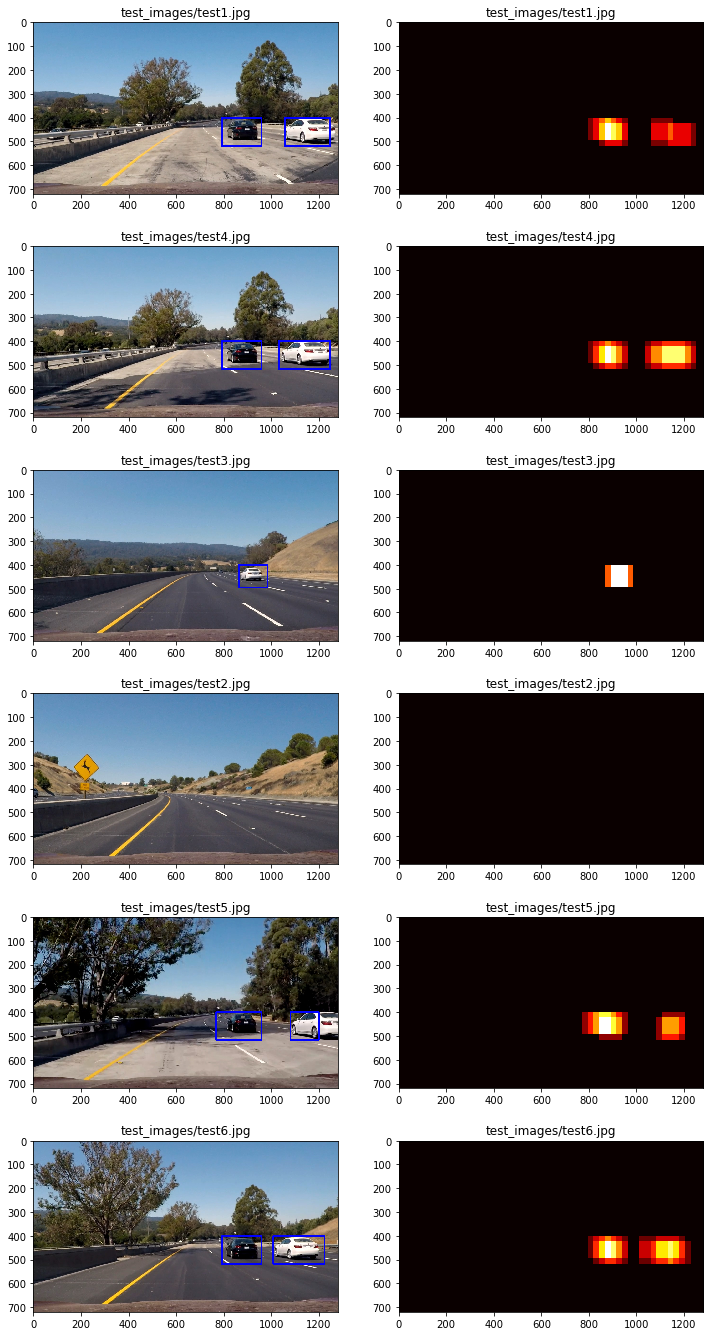

In [72]:
fig = plt.figure(figsize=(12, 24))
viz.visualize(6, 2, out_images, out_titles)

## Step5: Develop video stream processing pipeline

In [73]:
# Import everything needed to edit / save / watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

car_finder = detection.car_finder(scale, [ystart, ystop], orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, X_scaler, svc)

output = 'output_images/final_output_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(car_finder.process_image)
# %time
test_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video output_images/final_output_project_video.mp4
[MoviePy] Writing video output_images/final_output_project_video.mp4


100%|█████████▉| 1260/1261 [3:17:10<00:09,  9.17s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/final_output_project_video.mp4 

